In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import random

import matplotlib as mlp
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from scipy.optimize import curve_fit


import control
import make_query
import mining
import queries
import utils
import visualizations


### Importing Temporal User Data from:
- Uniswap
- Compound
- Decentraland
- AAVE
- Balancer
- 1INCH

The timeframe is from 1638334800 to 1648785600

In [2]:
# Open all the data

# Aggregate and add defi label

# bipatite matching like with amazon

In [3]:
aave = pd.read_csv("user_prediction_data/aave_data.csv")
axie = pd.read_csv("user_prediction_data/axie_data.csv")
balancer = pd.read_csv("user_prediction_data/balancer_data.csv")
compound = pd.read_csv("user_prediction_data/compound_data.csv")
decentraland = pd.read_csv("user_prediction_data/decentraland_data.csv")
oneInch = pd.read_csv("user_prediction_data/one_inch_data.csv")
uniswap = pd.read_csv("user_prediction_data/uniswap_data.csv")


In [4]:
def extract_users(df, col_name1, col_name2="", time_col="timestamp"):
    users = df[[col_name1, time_col]]
    users.columns = ["address", "time"]
    
    if col_name2 != "":
        more_users = df[[col_name2, time_col]]
        more_users.columns = ["address", "time"]
        users = pd.concat([users, more_users], axis=0)
    
    users.drop_duplicates()
    print(users.columns)
    
    return users


In [5]:
aave_users = extract_users(aave, "user.id")
aave_users["DeFi_APP"] = "Aave"
axie_users = extract_users(axie, "from.id", "to.id")
axie_users["DeFi_APP"] = "Axie"
balancer_users = extract_users(balancer, "userAddress.id")
balancer_users["DeFi_APP"] = "Balancer"
compound_users = extract_users(compound, "to", "from", "blockTime")
compound_users["DeFi_APP"] = "Compound"
decentraland_users = extract_users(decentraland, "buyer", "seller")
decentraland_users["DeFi_APP"] = "Decentraland"
one_inch_users = extract_users(oneInch, "from.id", "to.id")
one_inch_users["DeFi_APP"] = "1Inch"
uniswap_users = extract_users(uniswap, "sender", "to")
uniswap_users["DeFi_APP"] = "UniswapV2"


Index(['address', 'time'], dtype='object')
Index(['address', 'time'], dtype='object')
Index(['address', 'time'], dtype='object')
Index(['address', 'time'], dtype='object')
Index(['address', 'time'], dtype='object')
Index(['address', 'time'], dtype='object')
Index(['address', 'time'], dtype='object')


C:\Users\gridl\AppData\Local\Temp/ipykernel_16032/2943698597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aave_users["DeFi_APP"] = "Aave"
C:\Users\gridl\AppData\Local\Temp/ipykernel_16032/2943698597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balancer_users["DeFi_APP"] = "Balancer"


In [6]:
dfs = [aave_users, axie_users, balancer_users, compound_users, decentraland_users, one_inch_users, uniswap_users]

user_data = pd.concat(dfs)

#user_data.drop_duplicates(subset=user_data.columns.difference(['time']))


In [7]:
sorted_user_data = user_data.sort_values(by = ["time"])
print(sorted_user_data.shape)

train_data = sorted_user_data.head(int(len(sorted_user_data)*(0.8)))
print(train_data.shape)


(301518, 3)
(241214, 3)


In [8]:
# this is generating a bipartite graph that is will have the the defi apps as one row and the addresses as another


def generate_bipartite_graph(df, source, target, edge):
    top = set(df[source])
    bot = set(df[target])
    
    G_nums = nx.from_pandas_edgelist(
        df, source, target, edge)
    edges = G_nums.edges(data=True)
    
    G_bi = nx.Graph()
    G_bi.add_nodes_from(top, bipartite=0)
    G_bi.add_nodes_from(bot, bipartite=1)
    G_bi.add_edges_from(edges)
    print(G_bi)
    
    return G_bi




In [9]:

# Dataframe to get counts for the number of times a user used a platform
df_count = sorted_user_data.groupby(
    ["address", "DeFi_APP"], as_index=False).size()


# testing on a random subset for visualization
df_count_small = df_count.sample(frac=0.1, random_state=34)
print(df_count_small.shape)

# generating the bipartite graph
G_bi = generate_bipartite_graph(df_count_small, "DeFi_APP", "address", "size")


(4472, 3)
Graph with 4453 nodes and 4472 edges


In [10]:
#nx.draw(G_bi)
nx.is_connected(G_bi)

False

In [11]:
conn = False
n=1
while conn == False:
    df_count_small = df_count.sample(frac=0.1, random_state=n)
    G_bi = generate_bipartite_graph(df_count_small, "DeFi_APP", "address", "size")
    conn = nx.is_connected(G_bi)
    n+=1
print("Random State:", str(n))

Graph with 4466 nodes and 4472 edges
Graph with 4460 nodes and 4472 edges
Graph with 4453 nodes and 4472 edges
Graph with 4453 nodes and 4472 edges
Graph with 4448 nodes and 4472 edges
Graph with 4459 nodes and 4472 edges
Graph with 4449 nodes and 4472 edges
Graph with 4445 nodes and 4472 edges
Graph with 4455 nodes and 4472 edges
Graph with 4452 nodes and 4472 edges
Random State: 11


12

In [12]:
# get layout
print("Getting Layout")
top = nx.bipartite.sets(G_bi)[0]
pos = nx.bipartite_layout(G_bi, top)

print("Getting adjacency matrix")
# get adjacency matrix
A = nx.adjacency_matrix(G_bi)
A = A.toarray()

print(A)



Getting Layout
Getting adjacency matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Remove 25% of the edges
proportion_edges = 0.25
# this is our test set
edge_subset = random.sample(G_bi.edges(), int(proportion_edges * G_bi.number_of_edges()))

# Create a copy of the graph and remove the edges
B_train = G_bi.copy()
B_train.remove_edges_from(edge_subset)
print("train:", B_train)

B_test = nx.Graph()
B_test.add_edges_from(edge_subset)
print("train:", B_test)


train: Graph with 4452 nodes and 3354 edges
train: Graph with 1122 nodes and 1118 edges


C:\Users\gridl\AppData\Local\Temp/ipykernel_16032/2499527120.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(G_bi.edges(), int(proportion_edges * G_bi.number_of_edges()))


Neighbor methods will only predict existing edges between the same sets. This is because two vertices from different sets will never share common neighbors, resulting in a 0 MAP score. 

In [14]:
A_train = nx.adjacency_matrix(B_train)
A_train = A_train.toarray()
A_train.shape




(4452, 4452)

In [18]:
A = cp.array(A)
A_train = cp.array(A_train)

In [19]:
# eigenvalue decomposition
V_train, U_train = cp.linalg.eigh(A_train)
print("Found Eigenvalue Decomposition!")
# U.T * Atest * U
target_V = U_train.T @ A @ U_train
print("Found Target!")
# take only the diagonals
target_V = cp.diag(target_V)


Found Eigenvalue Decomposition!
Found Target!


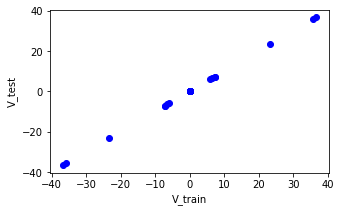

In [20]:
# plot the pattern
plt.figure(figsize=(5, 3))
plt.xlabel("V_train")
plt.ylabel("V_test")
plt.scatter(V_train.get(), target_V.get(), c='b')
plt.show()

In [21]:
# odd path counting kernel function
class OddPathCountingKernel:
    def __init__(self):
        self.a1 = 0
        self.a3 = 0
        self.a5 = 0
        self.a7 = 0
        
    def func(self, V, a1, a3, a5, a7):   
        return V * a1 + V**3 * a3 + V**5 * a5 + V**7 * a7
    def fit(self, V_train, target_V):
        # do curve fitting
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.a1, self.a3, self.a5, self.a7 = popt
    def pred(self, V_train):
        return self.func(V_train, self.a1, self.a3, self.a5, self.a7)

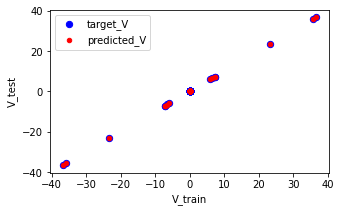

In [78]:
# fit kernel function

for kernel in [OddPathCountingKernel() ]:
    print(kernel)
    # fit the kernel to the data    
    kernel.fit(V_train.get(), target_V.get())
    # predict the output
    V_pred = kernel.pred(V_train.get())
    # assume our function is exponential V_train with alpha = 0.6
    plt.figure(figsize=(5, 3))
    plt.xlabel("V_train")
    plt.ylabel("V_test")
    plt.scatter(V_train.get(), target_V.get(), c='b', label="target_V", s=40)
    plt.scatter(V_train.get(), V_pred, c='r', label="predicted_V", s=20)
    plt.legend()
    plt.savefig("regression_fit.png")
    plt.show()
    
    # transformation
    Apred = U_train @ cp.diag(cp.array(V_pred)) @ U_train.T
    Apred = Apred.real
    # make edges of prediction
    pred = [(n, m, Apred[i, j]) for i, n in enumerate(G_bi.nodes()) for j, m in enumerate(G_bi.nodes())]
    # create graph
    G_pred = nx.Graph()
    G_pred.add_weighted_edges_from(pred)
    # evaluate MAP and precision
    

In [76]:
def ROC_PRC(pred, G):
    # prediction score
    y_score = [p[2].get() for p in pred]
    # groundtruth label
    y_true = [G.has_edge(p[0], p[1]) for p in pred]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # precision-recall curve
    y_score = np.array(y_score)
    y_true = np.array(y_true)

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_true,  y_score)
    ax1.plot(fpr, tpr)
    ax1.set_title("Precision-Recall Curve")
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    
    # receiver-operating characteristic curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    ax2.plot(fpr, tpr)
    ax2.set_title("ROC Curve, AUC = {:.2f}".format(
        metrics.roc_auc_score(y_true, y_score)))
    ax2.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    plt.savefig("curve.png")
    plt.show()


In [48]:
pred_txs = pred[0:5000000]

In [45]:
len(pred)

19820304

In [ ]:
# Remove 25% of the edges
proportion_edges = 0.5
# this is our test set
edge_subset_jc = random.sample(G_bi.edges(), int(proportion_edges * G_bi.number_of_edges()))

# Create a copy of the graph and remove the edges
JC_train = G_bi.copy()



In [50]:
jaccard_pred = list(nx.jaccard_coefficient(B_train))


In [58]:
len(jaccard_pred)

9904572

In [62]:
jaccard_pred_users = []
for j in jaccard_pred:
    if j[2] != 0:
        jaccard_pred_users.append(j)

jaccard_pred_users = sorted(jaccard_pred_users, key=lambda x: x[2], reverse=True)

[('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0xdb32f521a2426b5e7150eb73ef8d0916d809637b',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x0b152d7b2c1b04b8d42672be3bca3c3c56402e1f',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x9cb7bcec3664fac3830bfca64ae61fece75bfdef',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x853d526fd83e1da3baaac706db3283f026f94eb0',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0xabd5a8842740c151d18fece7eb901a7a185990c0',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x1749ad951fb612b42dc105944da86c362a783487',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0xcab72c950d3971baf129392edf644a6cb4a18be1',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x3c2262255793f2b4629f7b9a2d57ce78f7842a8d',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x10e4f5559d3a5ca450389ef84b29a767c1b24a56',
  1.0),
 ('0x9a98a1edd7b1c8e34a2d657eefa718d0f8434ac8',
  '0x693d196cd3c

In [69]:
for j in jaccard_pred:
    Nu = set(G_bi.neighbors(j[0]))
    Nv = set(G_bi.neighbors(j[1]))
    
    N_inter = Nu.intersection(Nv)
    if len(N_inter) > min(len(Nu), len(Nv)):
        print(j, Nu, Nv)


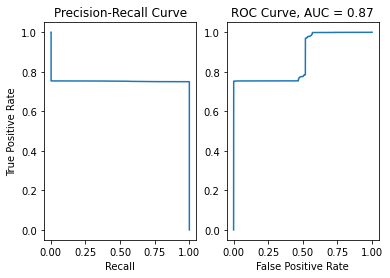

In [77]:
ROC_PRC(pred_txs, G_bi)

In [70]:
def MAP(G_test, G_pred, thres=0):
    # calculate avePrecision for each node and its neighbors
    avePs = []

    # loop through every node
    for node in tqdm(G_test.nodes()):
        # get predicted edges sorted in ranking order
        rankedPredWeights = sorted(
            G_pred[node].items(), key=lambda x: -x[1]['weight'])
        # only include edges that exist i.e. predicted rank / weight > threshold
        rankedPred = filter(
            lambda x: x[1]['weight'] > thres, rankedPredWeights)
        # get the rank
        pred = [x[0] for x in rankedPred]
        # calculate rel (existence of predicted edge in the groundtruth/actual set of edges)
        # get groundtruth neighbors
        gt = set(G_test[node])
        rel = np.array([x in gt for x in pred])
        # calculate P accumulative average of precision
        predLength = len(pred)
        P = np.array([
            sum(rel[:i+1])/len(rel[:i+1]) for i in range(predLength)
        ])
        # calculate aveP
        aveP = (rel @ P)/len(gt)
        # keep track of results
        avePs.append(aveP)
    MAPvalue = sum(avePs) / len(avePs)
    print("MAP: {}".format(MAPvalue))
    return MAPvalue

In [75]:
pred_sorted = sorted(pred, key=lambda x: x[2], reverse=True)
len(pred_sorted)

KeyboardInterrupt: 

In [ ]:
pred_txs = pred_sorted[0:5000000]

In [73]:
G_pred = nx.Graph()
G_pred.add_weighted_edges_from(pred_txs)

MAP(B_test, G_pred)

100%|██████████| 1122/1122 [1:07:09<00:00,  3.59s/it]

MAP: 0.006444603610700727


0.006444603610700727

44724